> This notebook is adapted from [François Lespinasse' script](https://github.com/sangfrois/ds_prep/blob/dev/physio/notebooks/ecg_gradient_removal.ipynb).
<br> The ECG cleaning procedure is based on [Bottenhorn et al., 2022 article](https://www.biorxiv.org/content/10.1101/2021.04.01.437293v3.abstract).


# ECG processing pipeline

Clean and process ECG signal acquired in an MRI environment using a Multi Band Multi-Echo sequence:
- TR = 2.65 s
- TE1 = 16.40 ms; TE2 = 32.16 ms; TE3 = 47.92 ms
- flip angle = 73°
- voxel size = 2 mm × 2 mm × 2 mm
- FOV = 208 mm
- matrix size = 104 × 104
- 70 slices
- multiband acceleration factor = 2)

## Import required python packages

In [1]:
import warnings
warnings.filterwarnings("ignore")
import math
import pandas as pd
import numpy as np
import os
import json
import neurokit2 as nk
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal

## Set general parameters

In [2]:
#general
path_segmented_data = "/scratch/mepicard/physio_data/emotionvideos/"
sub = "sub-03"
ses = "ses-002"
run = "02" #the first experimental run is tagged as 02
#Physio
sampling_rate = 10000
ch_name = "ECG"
#fMRI
tr = 2.65
mb = 2
slices = 70

## Load ECG signal

ECG signal taken from:
- Task: emotionvideos
- Subject: sub-03
- Session: ses-002
- Run: run-01

In [3]:
def load_json(filename):
    tmp = open(filename)
    data = json.load(tmp)
    tmp.close()
    
    return data

def load_segmented_runs(source, sub, ses, run=None):
    """
    """
    data_tsv, filenames = [], []
    files_tsv = [f for f in os.listdir(os.path.join(source, sub, ses)) if 'tsv.gz' in f]
    #Remove files ending with _01
    files_tsv = [f for f in files_tsv if '_01.' not in f]
    if run is not None:
        files_tsv = [f for f in files_tsv if f'_{run}.' in f]

    for tsv in files_tsv:
        filename = tsv.split(".")[0]
        filenames.append(filename)
        print(f"---Reading data for {sub} {ses}: run {filename[-2:]}---")
        json = filename+".json"
        print("Reading json file")
        data_json = load_json(os.path.join(source, sub, ses, json))
        print("Reading tsv file")
        data_tsv.append(pd.read_csv(os.path.join(source, sub, ses, tsv),
                                    sep="\t", compression="gzip",
                                    names=data_json["Columns"]))
    
    return data_tsv, filenames

In [4]:
data, filenames = load_segmented_runs(path_segmented_data, sub, ses, run)
ecg, filenames = data[0]['ECG'], filenames[0]
time = data[0]['time']

---Reading data for sub-03 ses-002: run 02---
Reading json file
Reading tsv file


### Visualize raw ECG

Text(0, 0.5, 'Amplitude')

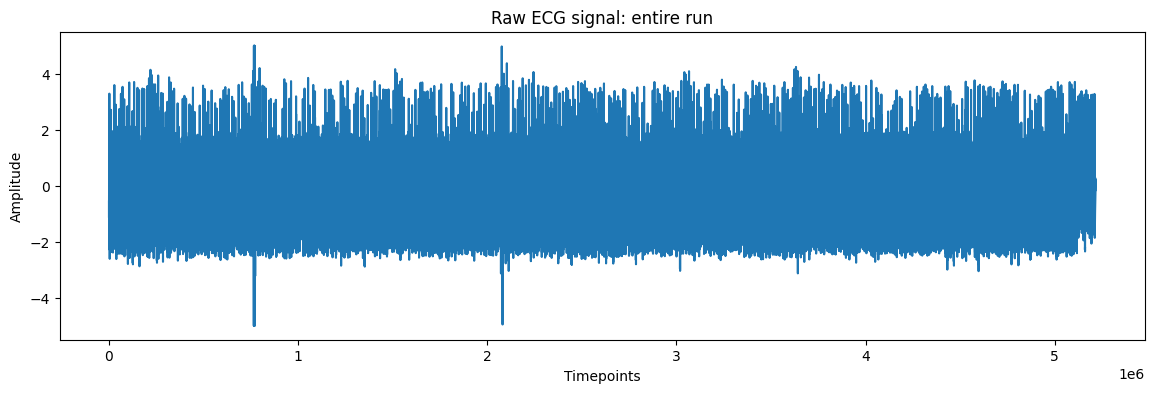

In [5]:
plt.figure(figsize=(14,4))
plt.plot(ecg)
plt.title("Raw ECG signal: entire run")
plt.xlabel("Timepoints")
plt.ylabel("Amplitude")

Text(0, 0.5, 'Amplitude (mV)')

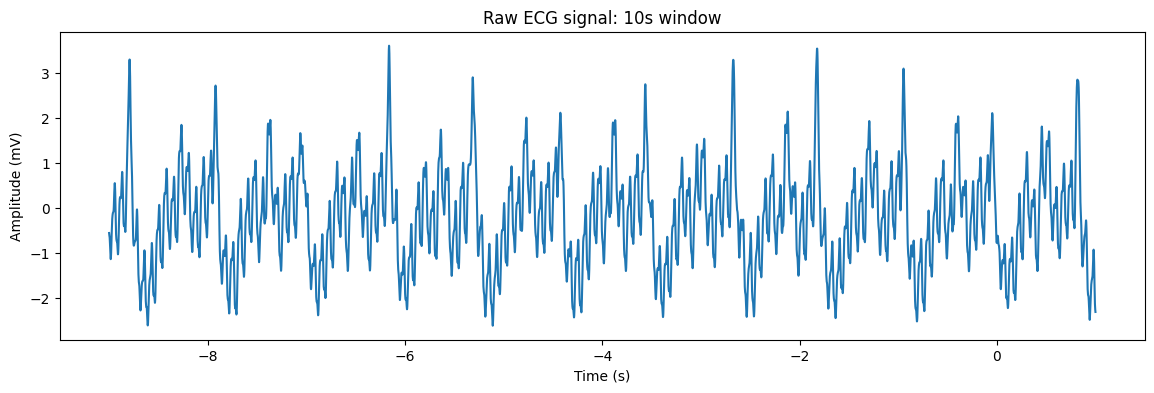

In [7]:
plt.figure(figsize=(14,4))
plt.plot(time[:sampling_rate*10], ecg[:sampling_rate*10])
plt.title("Raw ECG signal: 10s window")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (mV)")

## Clean ECG signal

In [8]:
def _comb_band_stop(notches, nyquist, filtered, Q, sampling_rate):
    """
    A serie of notch filters aligned with the scanner gradient's harmonics
    Biopac Systems, Inc. Application Notes: application note 242
    ECG Signal Processing During fMRI
    https://www.biopac.com/wp-content/uploads/app242x.pdf
    """
    # band stoping each frequency specified with notches dict
    for notch in notches:
        for i in np.arange(1, (nyquist / notches[notch])):
            f0 = notches[notch] * i
            w0 = f0/nyquist
            b,a = signal.iirnotch(w0, Q)
            filtered = signal.filtfilt(b, a, filtered)
    return filtered

def _consecutive(data, stepsize=0.000501):
    """
    reference: https://github.com/62442katieb/mbme-physio-denoising/blob/main/notebooks/denoising_eda.ipynb
    """
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

def _butter_highpass(cutoff, fs, order=5):
    """
    reference: https://github.com/62442katieb/mbme-physio-denoising/blob/main/notebooks/denoising_eda.ipynb
    """
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def _butter_highpass_filter(data, cutoff, fs, order=5):
    """
    reference: https://github.com/62442katieb/mbme-physio-denoising/blob/main/notebooks/denoising_eda.ipynb
    """
    b, a = _butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

def _fourier_freq(timeseries, d, fmax):
    """
    reference: https://github.com/62442katieb/mbme-physio-denoising/blob/main/notebooks/denoising_eda.ipynb
    """
    fft = np.fft.fft(timeseries)
    freq = np.fft.fftfreq(timeseries.shape[-1], d=d)
    fft_db = 10 * np.log10(abs(fft))
    limit = np.where(freq >= fmax)[0][0]
    return fft, fft_db, freq, limit

In [9]:
def _ecg_clean_bottenhorn(ecg_signal, sampling_rate=10000., tr=1.49, mb=4, slices=60, Q=100):
    """
    https://github.com/62442katieb/mbme-physio-denoising/blob/main/notebooks/denoising_eda.ipynb
    """
    # Setting scanner sequence parameters
    nyquist = np.float64(sampling_rate/2)
    notches = {'slices': slices / mb / tr,
               'tr': 1 / tr}
    # remove baseline wandering
    filtered = nk.signal_filter(ecg_signal,
                                sampling_rate=int(sampling_rate), lowcut = 2)
    # Filtering at specific harmonics, with trigger timing info
    filtered = _comb_band_stop(notches, nyquist, filtered, Q, sampling_rate)
    # bandpass filtering
    filtered = nk.signal_filter(filtered, sampling_rate=sampling_rate, lowcut=2,
                                 highcut=20, method='butter', order=5)

    return filtered

In [10]:
def plot_fft_ecg(ecg, fft_ecg, freq, time, sampling_rate=10000):
    gridkw = dict(width_ratios=[2,1])
    fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw=gridkw, figsize=(20,4))
    plt.tight_layout(pad=2)

    sns.lineplot(signal.decimate(time,10)[sampling_rate:sampling_rate*10][:sampling_rate], 
                 signal.decimate(ecg, 10)[sampling_rate:sampling_rate*10][:sampling_rate], 
                 linewidth=1, ax=ax1) #array, top subplot

    sns.lineplot(freq[1:sampling_rate*5], 
                 fft_ecg.real[1:sampling_rate*5], 
                 ax=ax2, linewidth=1)#bottom subplot
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Amplitude (mV)')
    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_yticklabels([0, -10, -5, 0, 5, 10, 15, 20, 25])
    ax2.set_ylabel('Power (x10,000)')
    plt.show()

### Apply Fourier transformation

In [11]:
fft_ecg = np.fft.fft(ecg)
freq = np.fft.fftfreq(ecg.shape[-1], d=0.00005)
fft_ecg_db = 10 * np.log10(abs(fft_ecg)) #log-transformed Fourier

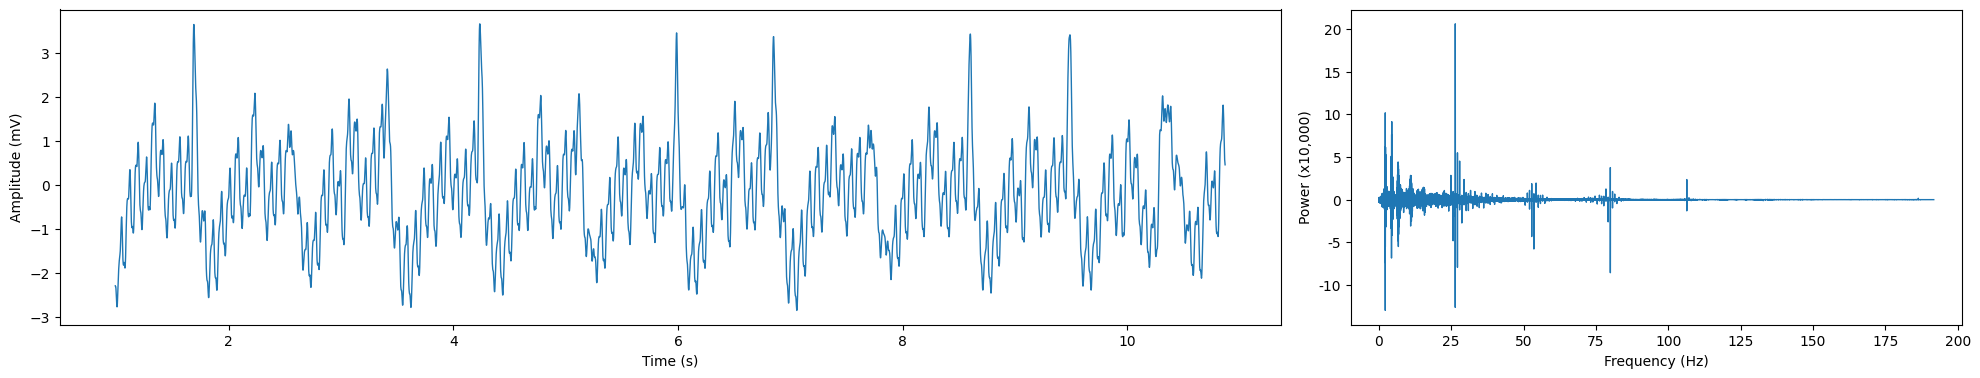

In [13]:
plot_fft_ecg(ecg, fft_ecg, freq, time, sampling_rate=10000)

### Clean respiration-related noise
 Using 2Hz high-pass filter

In [14]:
ecg_hp = _butter_highpass_filter(ecg, 2, sampling_rate)
#Fourier transformed
ecg_hp_fft = np.fft.fft(ecg_hp)
freq_hp_fft = np.fft.fftfreq(ecg_hp.shape[-1], d=0.00005)

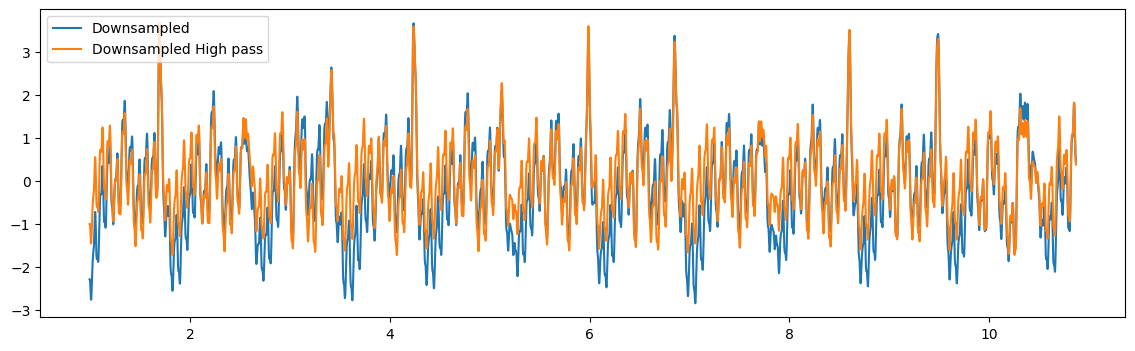

In [16]:
plt.figure(figsize=(14,4))

plt.plot(signal.decimate(time,10)[10000:100000][:sampling_rate],
         signal.decimate(ecg,10)[10000:100000][:sampling_rate], label='Downsampled')
plt.plot(signal.decimate(time,10)[10000:100000][:sampling_rate],
         signal.decimate(ecg_hp,10)[10000:100000][:sampling_rate], label='Downsampled High pass')
plt.legend()

<div class="alert alert-info">
`signal.decimate` function is used to downsample the signal.
    
https://en.wikipedia.org/wiki/Downsampling_(signal_processing)
</div>

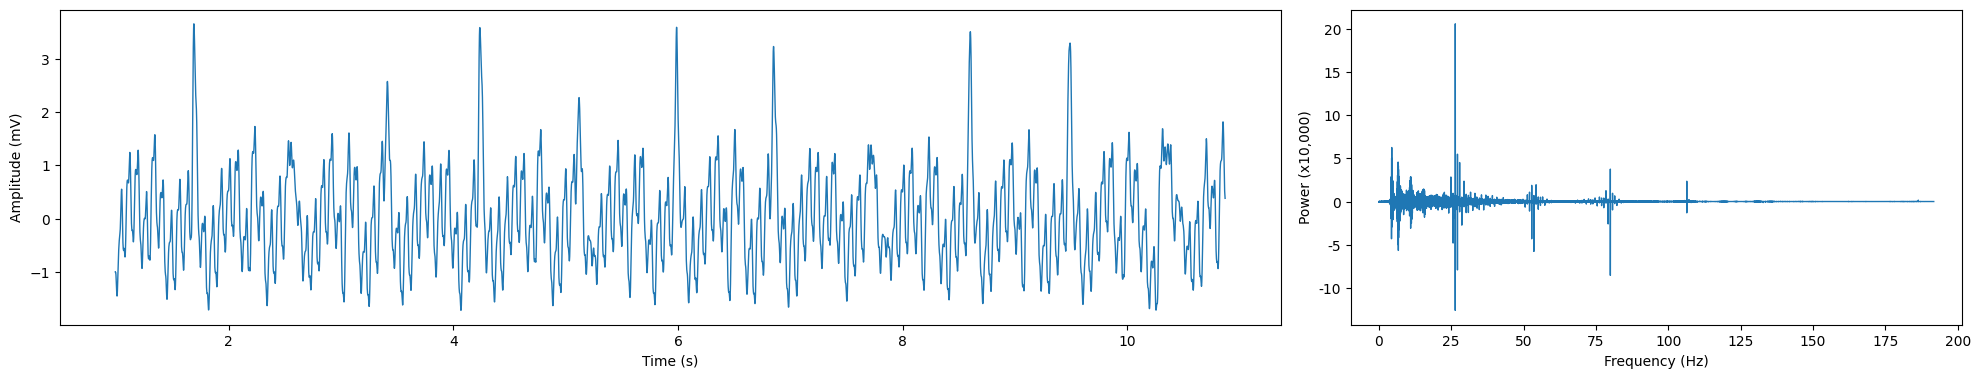

In [18]:
plot_fft_ecg(ecg_hp, ecg_hp_fft, freq_hp_fft, time, sampling_rate=10000)

### Comb filters
See https://shwestrick.github.io/2020/08/28/digital-reverb.html

#### Set filters paramaters

In [22]:
high_pass = 2
low_pass = 20
Q = 100
nyquist = sampling_rate/2

#Define notch filter parameters based on Bottenhorn et al., 2022
notches = {
    'slices': slices / mb /tr,
    'tr': 1/tr
}

In [23]:
ecg_hp_comb = _comb_band_stop(notches, nyquist, ecg_hp, Q, sampling_rate)

In [25]:
#Fourier transformed
ecg_hp_comb_fft = np.fft.fft(ecg_hp_comb)
freq_hp_comb = np.fft.fftfreq(ecg_hp_comb.shape[-1], d=0.0005)

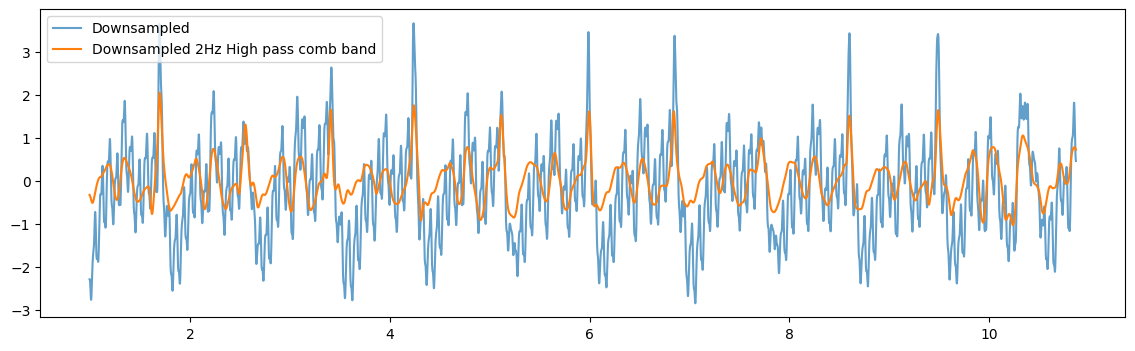

In [54]:
plt.figure(figsize=(14,4))

plt.plot(signal.decimate(time,10)[10000:100000][:sampling_rate],
         signal.decimate(ecg,10)[10000:100000][:sampling_rate], label='Downsampled', alpha=0.7)
plt.plot(signal.decimate(time,10)[10000:100000][:sampling_rate],
         signal.decimate(ecg_hp_comb,10)[10000:100000][:sampling_rate], label='Downsampled 2Hz High pass comb band')
plt.legend()

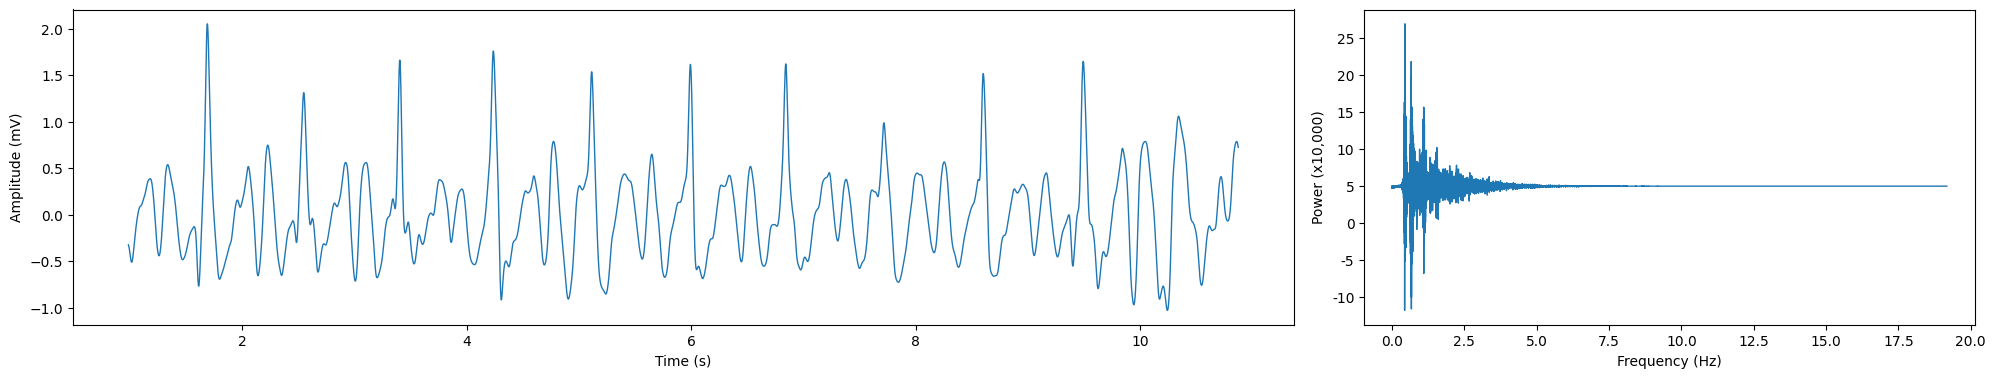

In [26]:
plot_fft_ecg(ecg_hp_comb, ecg_hp_comb_fft, freq_hp_comb, time, sampling_rate=10000)

### Low pass filter

(40 Hz)

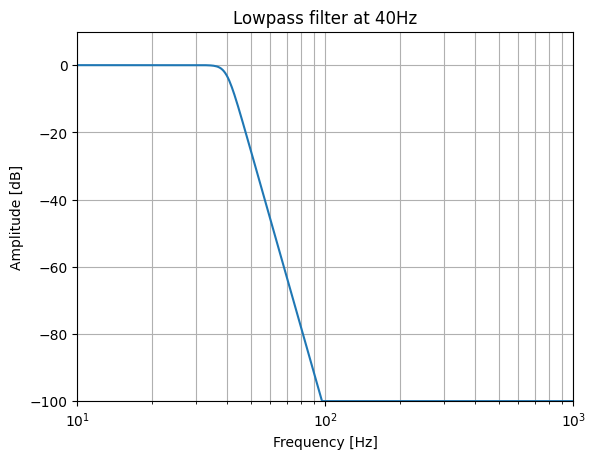

In [61]:
#lowpass IIR filter noise, per BioPac App242 instructions
sos = signal.iirfilter(13, 40, btype='lowpass', output='sos', fs=sampling_rate)
w, h = signal.sosfreqz(sos, 10000, fs=10000.)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.semilogx(w, 20 * np.log10(np.maximum(abs(h), 1e-5)))
ax.set_title('Lowpass filter at 40Hz')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude [dB]')
ax.axis((10, 1000, -100, 10))
ax.grid(which='both', axis='both')
plt.show()

In [59]:
ecg_hp_comb_lp = signal.sosfiltfilt(sos, ecg_hp_comb)

ecg_hp_comb_lp_fft = np.fft.fft(ecg_hp_comb_lp)
freq_hp_comb_lp = np.fft.fftfreq(ecg_hp_comb_lp.shape[-1], d=0.0005)

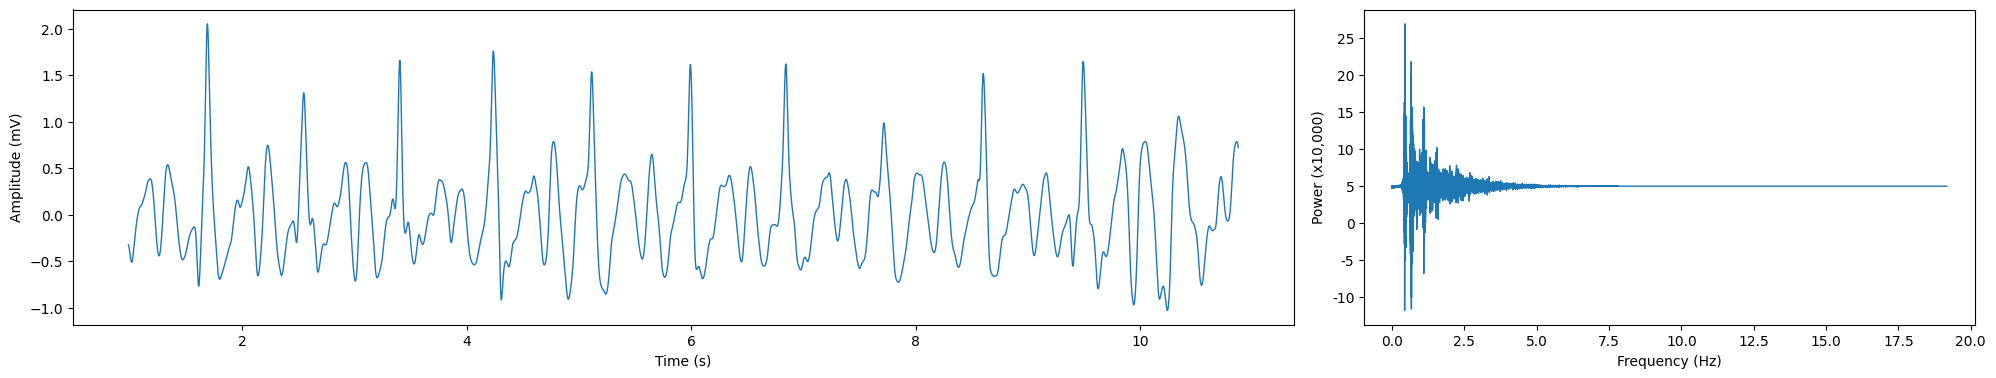

In [60]:
plot_fft_ecg(ecg_hp_comb_lp, ecg_hp_comb_lp_fft, freq_hp_comb_lp, time, sampling_rate=10000)

### Band pass filter 

(17 Hz)

In [75]:
#bandpass around 17Hz  per BioPac App242 instructions
f0 = 24.  # Frequency to be retained (Hz)
Q = 6  # Quality factor
w0 = f0/nyquist  # Normalized Frequency
# Design peak filter
low = 3 / nyquist
high = 34 / nyquist
order = 5
sos = signal.butter(order, [low, high], btype='band', output='sos')
ecg_hp_comb_lp_bp = signal.sosfiltfilt(sos, ecg_hp_comb_lp)
ecg_hp_comb_lp_bp_fft = np.fft.fft(ecg_hp_comb_lp_bp)
freq_hp_comb_lp_bp = np.fft.fftfreq(ecg_hp_comb_lp_bp.shape[-1], d=0.0005)

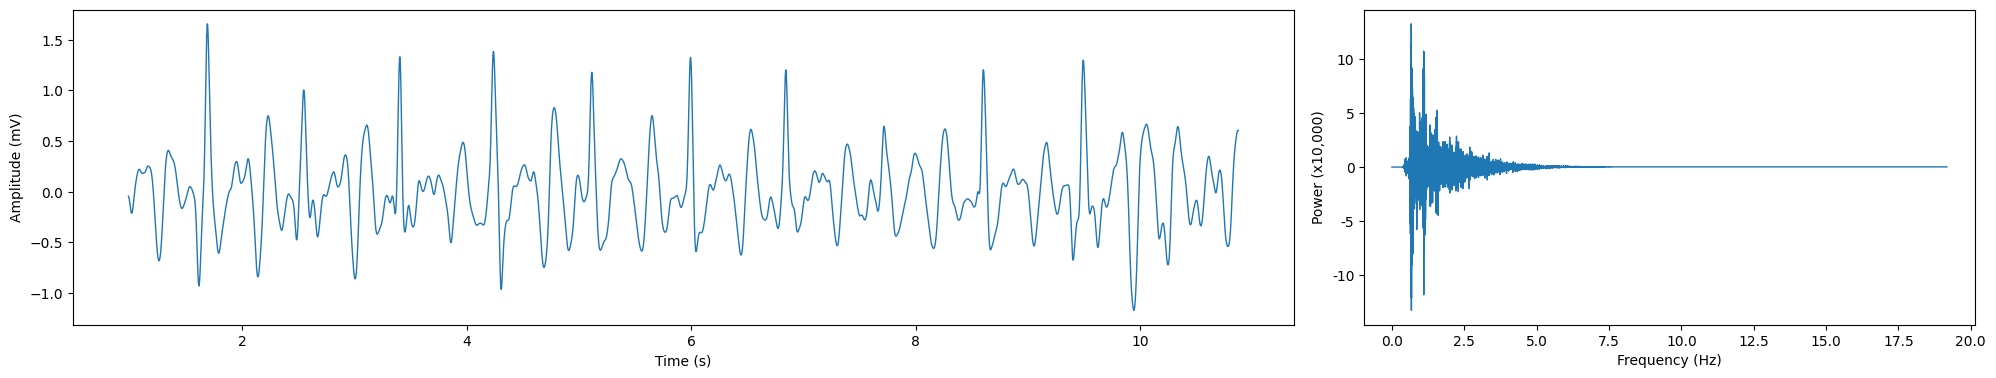

In [76]:
plot_fft_ecg(ecg_hp_comb_lp_bp, ecg_hp_comb_lp_bp_fft, freq_hp_comb_lp_bp, time, sampling_rate=10000)

## Visualize ECG filtered signal step-by-step

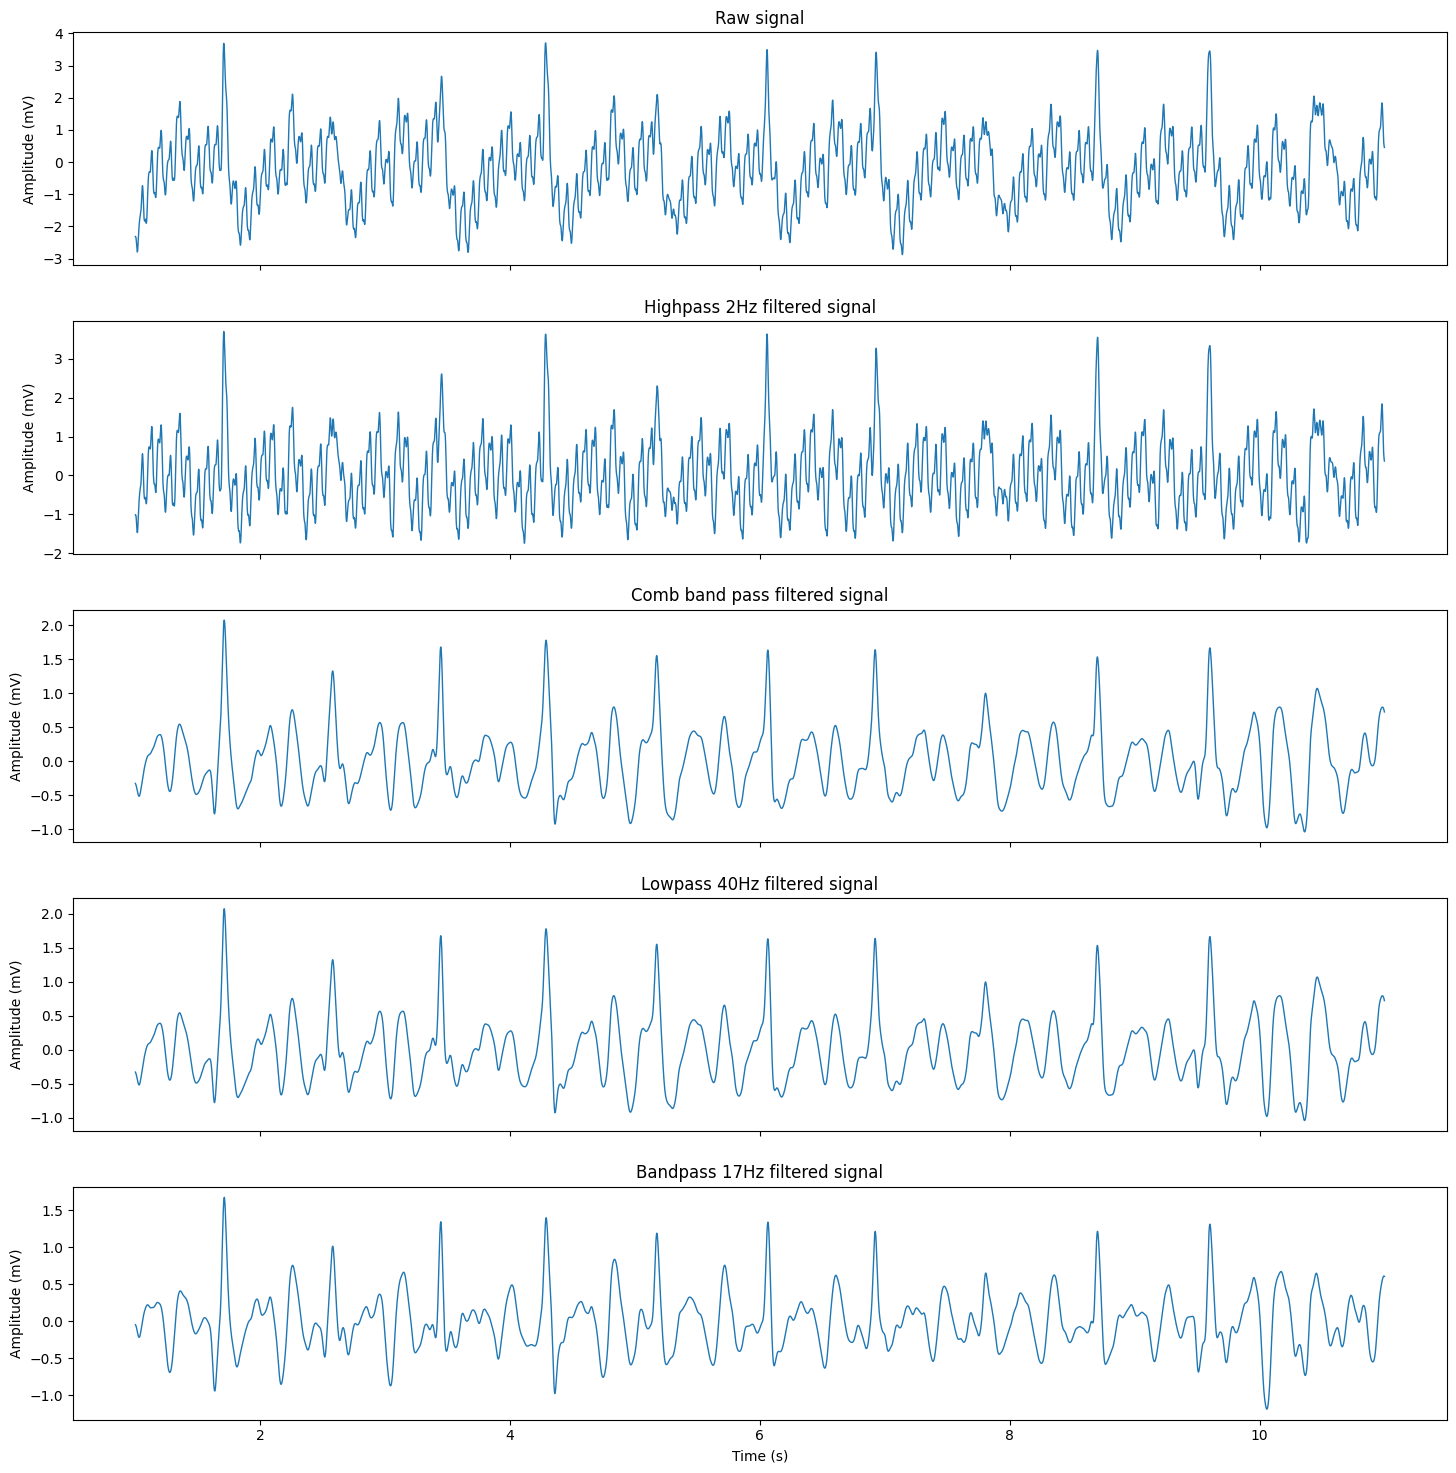

In [95]:
fig,ax = plt.subplots(nrows=5, figsize=(15,15), sharey=False, sharex=True)
plt.tight_layout(pad=3)
f = sns.lineplot(time[100000:200000], ecg[100000:200000], linewidth=1, ax=ax[0])
f.set(title="Raw signal", ylabel="Amplitude (mV)")
g = sns.lineplot(time[100000:200000], ecg_hp[100000:200000], linewidth=1, ax=ax[1])
g.set(title="Highpass 2Hz filtered signal", ylabel="Amplitude (mV)")
h = sns.lineplot(time[100000:200000], ecg_hp_comb[100000:200000], linewidth=1, ax=ax[2])
h.set(title="Comb band pass filtered signal", ylabel="Amplitude (mV)")
i = sns.lineplot(time[100000:200000], ecg_hp_comb_lp[100000:200000], linewidth=1, ax=ax[3])
i.set(title="Lowpass 40Hz filtered signal", ylabel="Amplitude (mV)")
j = sns.lineplot(time[100000:200000], ecg_hp_comb_lp_bp[100000:200000], linewidth=1, ax=ax[4])
j.set(title="Bandpass 17Hz filtered signal", ylabel="Amplitude (mV)")

plt.xlabel("Time (s)")


#plt.savefig("ecg_filtering_pipeline_output.png", dpi=300)